In [1]:
from IPython.display import FileLink

In [2]:
ls ../input/

Effnet-256-unfr.pth     res152-480-unfr_l1.pth     resnet152-480-unfreezed.pth
Effnet-500-unfr-1.pth   res152-480-unfr_l2.pth     resnet152-tran-freezed.pth
Effnet-B5-128-unfr.pth  resnet152-256-freezed.pth
he_challenge_data/      resnet152-480-unfr-fr.pth


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai.vision import *
# import kaggle
import pandas as pd
import numpy as np

In [5]:
# !wget https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip

In [6]:
# ! unzip HE_Challenge_data.zip

In [7]:
# import pathlib

In [8]:
train_df = pd.read_csv("../input/he_challenge_data/data/train.csv")
train_df.head()

image_id  category
0         0        77
1         1        81
2         2        52
3         3        72
4         4        58

In [9]:
train_df["category"].nunique()

102

In [10]:
train_df["category"].value_counts()

51    582
77    567
46    441
73    438
89    414
     ... 
21     90
7      90
1      90
27     90
45     90
Name: category, Length: 102, dtype: int64

In [11]:
import imagesize
train_df["width"] = 0
train_df["height"] = 0
train_df["aspect_ratio"] = 0.0
for idx, row in train_df.iterrows():
#     print(int(row["image_id"]))
    width, height = imagesize.get(f'../input/he_challenge_data/data/train/{int(row["image_id"])}.jpg')
    train_df.at[idx, "width"] = width
    train_df.at[idx, "height"] = height
    train_df.at[idx, "aspect_ratio"] = float(height) / float(width)

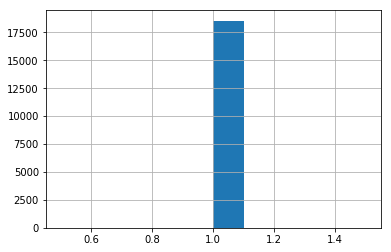

In [12]:
train_df["aspect_ratio"].hist()

In [ ]:
# path = Path("./data/train")
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0,
#                       max_zoom=1.1, max_lighting=0.2, max_warp=0.2,
#                       p_affine=0.75, p_lighting=0.75, xtra_tfms=None)
# data = (ImageList.from_csv(path, csv_name = '../train.csv', suffix = '.jpg')
#        .split_by_rand_pct()
#        .label_from_df()
#        .add_test_folder(test_folder = '../test')
#        .transform(tfms, size=248)
#        .databunch(num_workers=0,bs=16)
#        .normalize(imagenet_stats))

## Prepare DataBunch

In [13]:
path = Path("../input/he_challenge_data/data/train/")
def prepare_databunch(size=64, bs=128, transforms=get_transforms()):
    np.random.seed(0)
    data_source = (ImageList.from_csv(path, csv_name='../train.csv', suffix= '.jpg')
                   .split_by_rand_pct(0.3)
                   .label_from_df())
    data = (data_source.add_test_folder(test_folder='../test')
            .transform(transforms, size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

    return data

In [ ]:
# def prepare_databunch(size=64, bs=128, transforms=get_transforms()):
#     np.random.seed(0)
#     data_source = (ImageList.from_df(df=train_df, path=data_path/'train', cols='image')
#                     .split_by_rand_pct(0.1)
#                     .label_from_folder())
#     test_data_source = ImageList.from_df(df=sample_submissions, path=data_path/'test', cols='id')
#     data = (data_source.transform(transforms, size=size)
#                   .databunch(bs=bs)
#                   .normalize(imagenet_stats))
#     data.add_test(test_data_source)
#     return data

In [14]:
data = prepare_databunch(size=400,bs=64)

In [ ]:
# prepare_databunch(size=224, bs=256)

In [15]:
data

ImageDataBunch;

Train: LabelList (12978 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
77,81,52,72,58
Path: ../input/he_challenge_data/data/train;

Valid: LabelList (5562 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
51,69,84,46,37
Path: ../input/he_challenge_data/data/train;

Test: LabelList (2009 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: EmptyLabelList
,,,,
Path: ../input/he_challenge_data/data/train

In [16]:
data.c

102

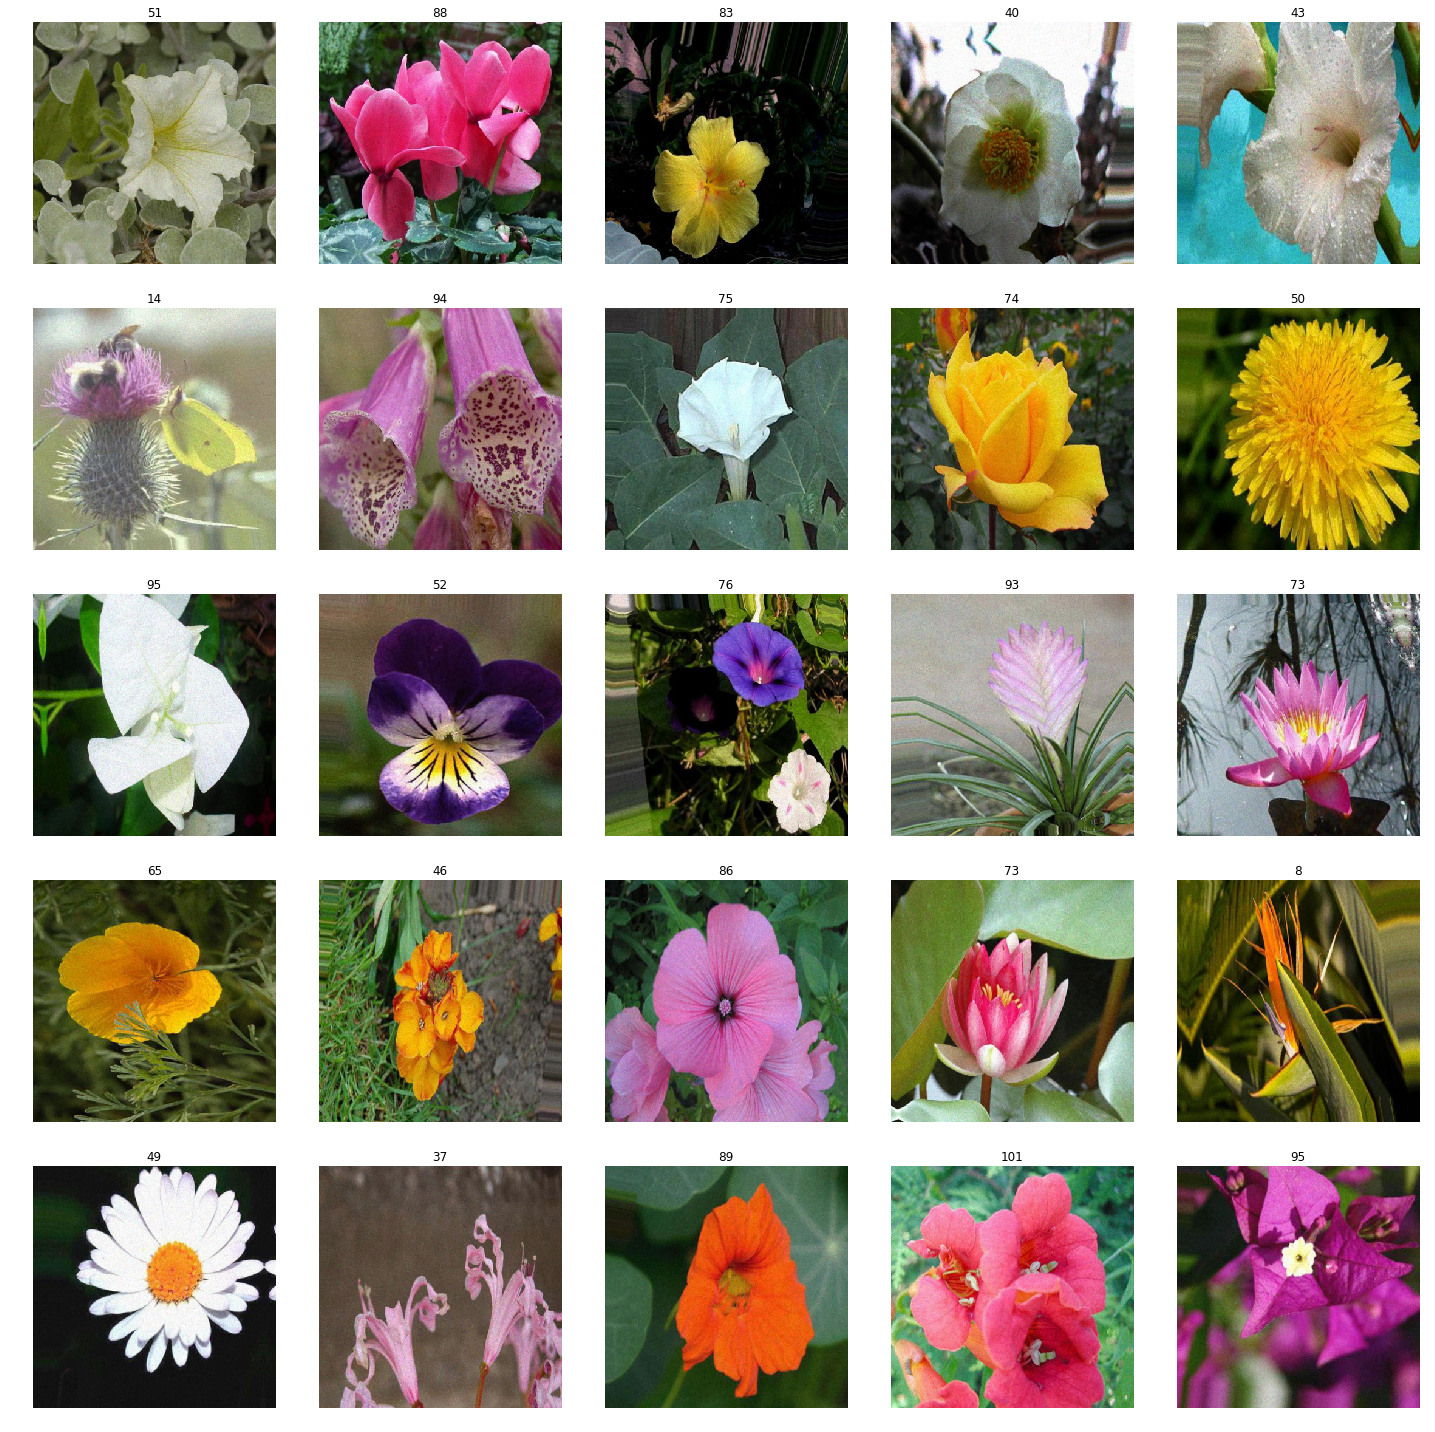

In [17]:
data.show_batch()

## Trying reset50

In [18]:
from fastai.metrics import accuracy, error_rate
import torch

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], model_dir=pathlib.PosixPath('/tmp/.cache/torch/checkpoints/')).to_fp16()

Min numerical gradient: 1.32E-02
Min loss divided by 10: 8.32E-03


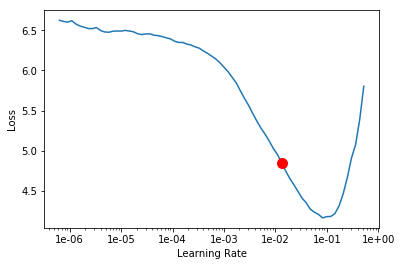

In [23]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.fit_one_cycle(10, max_lr=1.32e-02)

In [ ]:
learn.save('resnet50-freezed')

In [ ]:
ls './data/train/models/'

In [ ]:
FileLink('./data/train/resnet50-freezed.pth')

# Making Prediction Just for trained head

In [ ]:
def get_predictions(learner, dataset='test', get_classes=False):
    dataset_map = {
        'train': DatasetType.Train,
        'valid': DatasetType.Valid,
        'test': DatasetType.Test
    }
    dataset = dataset_map[dataset]
    preds = learner.get_preds(dataset)
    class_labels = np.argmax(preds[0], 1)
    if get_classes:
        predictions = [learner.data.classes[i] for i in class_labels]
    else:
        predictions = class_labels
    return predictions, preds[0]

In [ ]:
preds =get_predictions(learn)

In [ ]:
(preds[1][0])

In [ ]:
filenames = os.listdir('./data/test')
print(len(filenames))


In [ ]:
! rm -rf ./data/test/.DS_Store
len(filenames)

In [ ]:
filenames = os.listdir('./data/test')
print(len(filenames))

In [ ]:
for i in range(len(filenames)):
  filenames[i] = filenames[i][:-4]

In [ ]:
filenames[:5]

In [ ]:
def get_submision(preds):
    labelled_preds = []
    pred11 = preds
    for pred in pred11:
        labelled_preds.append(int(np.argmax(pred))+1)

    submission = pd.DataFrame(
        {'image_id': filenames,
         'category': labelled_preds,
        })
    submission = submission.sort_values(by=['image_id'])
    submission.to_csv('submission.csv',index=False)
    return submission

In [ ]:
submission = get_submision(preds[1])

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create_download_link(submission)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, max_lr=5e-5)

In [ ]:
learn.save('resnet50-unfreezed')

In [ ]:
preds = get_predictions(learn)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=6e-05)

## Progressive resize 128

In [ ]:
learn.data = prepare_databunch(size=128, bs=256)

In [ ]:
learn = learn.to_fp16()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(7, max_lr=9e-03)

In [ ]:
learn.unfreeze()

In [ ]:
learn = learn.to_fp16()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=5e-06)

In [ ]:
learn.freeze()

In [ ]:
learn.save('resnet50-freezed-128')

In [ ]:
# submitting again
preds = get_predictions(learn)
submission = get_submision(preds[1])
create_download_link(submission)

## 224

In [ ]:
!nvidia-smi

In [ ]:
learn.data = prepare_databunch(size=224, bs=256)
learn = learn.to_fp16()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, max_lr=9e-03)

In [ ]:
learn.save('resnet50-freezed-224')

In [ ]:
learn = learn.load('resnet50-freezed-224')

In [ ]:
learn = learn.to_fp16()
learn.model = torch.nn.DataParallel(learn.model)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(start_lr=1e-10, suggestion=True)

In [ ]:
# learn.recorder.plot(start_lr=1e-10, suggestion=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=7e-07)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(50,50))

In [ ]:
interp.plot_top_losses(9, figsize=(25,25))

In [ ]:
learn.save('resnet50-224-unfreezed')

In [ ]:
# prediction on test
preds = get_predictions(learn)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn = learn.load('resnet50-224-unfreezed')

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=9e-07)

In [ ]:
learn.save('resnet50-224-final')


In [ ]:
# prediction on test
preds = get_predictions(learn)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn = learn.load('resnet50-224-final')

# 480

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('./data/train/models/resnet50-224-final.pth')

In [ ]:
! nvidia-smi

In [ ]:
learn.data = prepare_databunch(size=480, bs=64)
learn = learn.to_fp16()

In [ ]:
# learn = None
# model = None
# import gc; gc.collect()
# torch.cuda.empty_cache()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(7, max_lr=8e-03)

In [ ]:
learn.save('resnet50-freezed-480')

In [ ]:
learn.load('resnet50-freezed-480')

In [ ]:
learn = learn.to_fp16()
learn.model = torch.nn.DataParallel(learn.model)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(start_lr=1e-10)

In [ ]:
learn.model.rem

In [ ]:
learn.model.module.state_dict()

In [ ]:
learn.fit_one_cycle(3, max_lr=9e-06)

In [ ]:
learn.save('resnet50-480-unfreezed')

In [ ]:
# prediction on test
preds = get_predictions(learn)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2, max_lr=1e-04)

In [ ]:
# prediction on test
preds = get_predictions(learn)
submission = get_submision(preds[1])
create_download_link(submission)

## Trying resnet152

In [ ]:
!mkdir ./data/train/models

In [ ]:
!ls ./data/train/models/

In [ ]:
! cp ../input/resnet152-256-freezed.pth ./data/train/models/

In [ ]:
data128 = prepare_databunch(size=128)

In [ ]:
learn152 = cnn_learner(data128, models.resnet152, metrics=[accuracy, error_rate]).to_fp16()

In [ ]:
learn152.model = torch.nn.DataParallel(learn152.model)

In [ ]:
learn152.lr_find()
learn152.recorder.plot()

In [ ]:
learn152.fit_one_cycle(1, max_lr=1e-02)

In [ ]:
learn152.save('res150-freezed')

In [ ]:
learn152.unfreeze()

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(3, max_lr=2e-06)

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
! nvidia-smi

In [ ]:
data256 = prepare_databunch(size=256, bs=64)

In [ ]:
learn152.data = data256
learn152 = learn152.to_fp16()

In [ ]:
learn152.lr_find()
learn152.recorder.plot()

In [ ]:
learn152.fit_one_cycle(5, max_lr=1e-04)

In [ ]:
learn152.save('res152-unfreezed-1')

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(3, max_lr=8e-07)

In [ ]:
learn152.save('resnet152-256-freezed')

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.load('resnet152-256-freezed')

In [ ]:
FileLink('./data/train/models/resnet152-256-freezed.pth')

In [ ]:
learn152.freeze()

In [ ]:
# learn=None
# import gc; gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# torch.cuda.set_device(0)
# torch.cuda.empty_cache()

In [ ]:
! nvidia-smi

In [ ]:
data480 = prepare_databunch(size=480,bs=24)

In [ ]:
# ! fuser -v /dev/nvidia*

In [ ]:
learn152.data = data480
learn152 = learn152.to_fp16()

In [ ]:
learn152

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
! nvidia-smi

In [ ]:
learn152.fit_one_cycle(5, max_lr=9e-03)

In [ ]:
learn152.save('resnet152-480-freezed')

In [ ]:
learn152.unfreeze()

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(3, max_lr=2e-06)

In [ ]:
learn152.save('resnet152-480-unfreezed')

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.freeze()

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(3, max_lr=6e-03)

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.save('resnet152-480-unfr-fr')

In [ ]:
FileLink('./data/train/models/resnet152-480-unfreezed.pth')

In [ ]:
learn152.unfreeze()

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(3, max_lr=7e-06)

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
ls

In [ ]:
learn152.lr_find()
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(3, max_lr=6.3e-07)

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.save('res152-480-unfr_l2')

In [ ]:
FileLink('./data/train/models/res152-480-unfr_l2.pth')

In [ ]:
learn152.freeze()

In [ ]:
learn152.lr_find(start_lr=1e-10)
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(2, max_lr=2.6e-09)

In [ ]:
learn152.save('resnet152-final-480')

In [ ]:
learn152 = learn152.load('res152-480-unfr_l2')

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
! nvidia-smi

## Trying Transforms

In [ ]:
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0,
#                       max_zoom=1.1, max_lighting=0.2, max_warp=0.2,
#                       p_affine=0.75, p_lighting=0.75, xtra_tfms=None)

In [ ]:
np.random.seed(0)
tmfs = zoom_crop(scale=(0.75,2), do_rand=True)
data_trans = prepare_databunch(size=480, bs=24, transforms=tmfs)

In [ ]:
# learn_trans = cnn_learner(data_trans, models.resnet152, metrics=[accuracy, error_rate]).to_fp16()

In [ ]:
learn152.data = data_trans

In [ ]:
learn152

In [ ]:
# learn_trans.model = torch.nn.DataParallel(learn_trans.model)

In [ ]:
# learn_trans = learn_trans.load('resnet152-final-480')

In [ ]:
learn152.freeze()

In [ ]:
learn152.lr_find(start_lr=1e-10)
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(5, max_lr=7e-03)

In [ ]:
learn152.save('resnet152-tran-freezed')

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
FileLink('./data/train/models/resnet152-tran-freezed.pth')

In [ ]:
learn152 = learn_trans.load('resnet152-tran-freezed')

In [ ]:
learn152.unfreeze()

In [ ]:
# learn152.lr_find(start_lr=1e-10)
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(5, max_lr=9.5e-09)

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.freeze()

In [ ]:
learn152.save('resnet152-tran-unfreezed')

In [ ]:
FileLink('./data/train/models/resnet152-tran-unfreezed.pth')

In [ ]:
learn152.lr_find()

In [ ]:
learn152.recorder.plot(suggestion=True)

In [ ]:
learn152.fit_one_cycle(4, max_lr=9e-06)

In [ ]:
# submitting again
preds = get_predictions(learn152)
submission = get_submision(preds[1])
create_download_link(submission)

In [ ]:
learn152.save('resnet152-tran-freezed2')


In [ ]:
FileLink('./data/train/models/resnet152-tran-freezed2.pth')

## Ensembling

In [ ]:
def get_predictions(learner, dataset='test', get_classes=False):
    dataset_map = {
        'train': DatasetType.Train,
        'valid': DatasetType.Valid,
        'test': DatasetType.Test
    }
    dataset = dataset_map[dataset]
    preds = learner.get_preds(dataset)
    class_labels = np.argmax(preds[0], 1)
    if get_classes:
        predictions = [learner.data.classes[i] for i in class_labels]
    else:
        predictions = class_labels
    return predictions, preds[0]

def ensemble_models(learners):
    valid_y = torch.from_numpy(list(learners.values())[0].data.valid_ds.y.items)
    valid_pred_scores = []
    test_pred_scores = []
    for name, learner in learners.items():
        valid_predictions, valid_scores = get_predictions(learner, 'valid')
        print(f'{name} validation accuracy {(valid_predictions == valid_y).float().mean()}')
        test_predictions, test_scores = get_predictions(learner, 'test')
        valid_pred_scores.append(valid_scores)
        test_pred_scores.append(test_scores)
    ensemble_valid_scores = sum(valid_pred_scores)/len(valid_pred_scores)
    ensemble_test_scores = sum(test_pred_scores)/len(test_pred_scores)
    ensemble_valid_predictions = np.argmax(ensemble_valid_scores, 1)
    ensemble_test_predictions = np.argmax(ensemble_test_scores, 1)
    print(f'ensemble valid accuracy {(ensemble_valid_predictions == valid_y).float().mean()}')
    return ensemble_test_predictions

In [ ]:
learners = {
    'resnet50': learn,
    'resnet152': learn152,
    'resnet152_trans': learn_trans
}

In [ ]:
test_predictions = ensemble_models(learners)

In [ ]:
test_predictions_classes = [learn.data.classes[x] for x in test_predictions]

In [ ]:
sample_submissions['predicted_class'] = test_predictions_classes

In [ ]:
sample_submissions.to_csv('r152_r50_ensemble_transforms3.csv', index=False)

In [ ]:
# !kaggle competitions submit -c dsnetxfastai -f r152_r50_ensemble_transforms2.csv -m "reset152 ensemble with transforms2 "